# 月牙形数据集

## make_moons

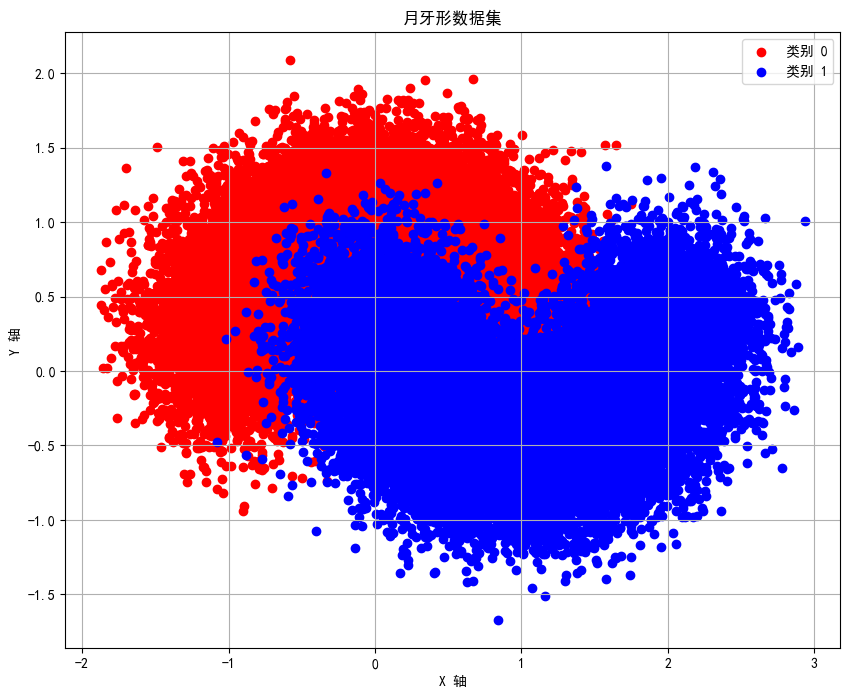

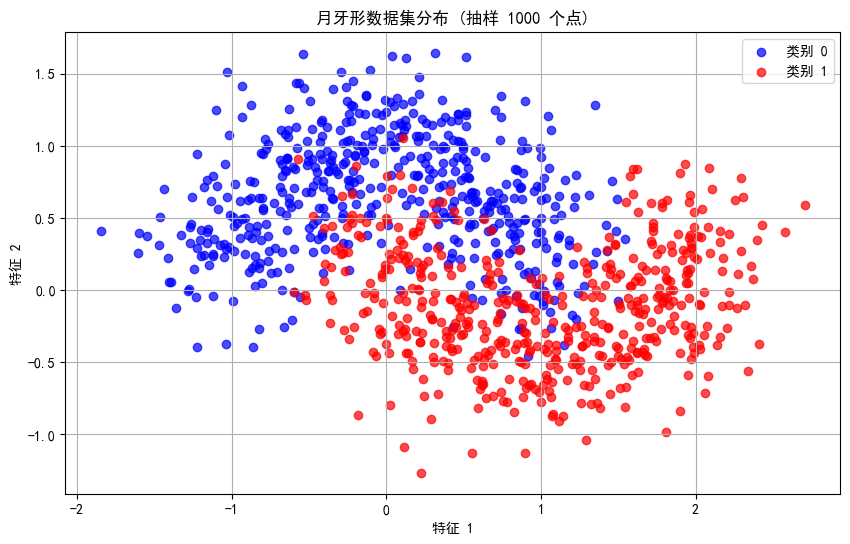

In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 使用make_moons生成月牙形数据集
X, y = make_moons(n_samples=50000, noise=0.3, random_state=42)

# 绘制数据
plt.figure(figsize=(10, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='类别 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='类别 1')
plt.title('月牙形数据集')
plt.xlabel('X 轴')
plt.ylabel('Y 轴')
plt.legend()
plt.grid(True)
plt.show()

#取1000个点
sample_size = 1000
plt.figure(figsize=(10, 6))
plt.scatter(X[:sample_size][y[:sample_size] == 0, 0], X[:sample_size][y[:sample_size] == 0, 1],
            color='blue', alpha=0.7, label='类别 0')
plt.scatter(X[:sample_size][y[:sample_size] == 1, 0], X[:sample_size][y[:sample_size] == 1, 1],
            color='red', alpha=0.7, label='类别 1')
plt.title('月牙形数据集分布 (抽样 {} 个点)'.format(sample_size))
plt.xlabel('特征 1')
plt.ylabel('特征 2')
plt.legend()
plt.grid(True)
plt.show()


# 并行集成学习


## 以决策树、SVC、逻辑回归为基分类器,硬投票

In [2]:
# 导入所需的分类器
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建基分类器
lr = LogisticRegression()
svc = SVC()
dt = DecisionTreeClassifier()

# 训练基分类器并评估
lr.fit(X_train, y_train)
svc.fit(X_train, y_train)
dt.fit(X_train, y_train)

# 在测试集上进行预测
lr_pred = lr.predict(X_test)
svc_pred = svc.predict(X_test)
dt_pred = dt.predict(X_test)

# 计算各个基分类器的准确率
print('逻辑回归准确率:', accuracy_score(y_test, lr_pred))
print('SVC准确率:', accuracy_score(y_test, svc_pred))
print('决策树准确率:', accuracy_score(y_test, dt_pred))

# 创建并训练硬投票集成模型
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('svc', svc), ('dt', dt)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

# 评估集成模型的准确率
voting_pred = voting_clf.predict(X_test)
print('集成模型准确率:', accuracy_score(y_test, voting_pred))


KeyboardInterrupt: 

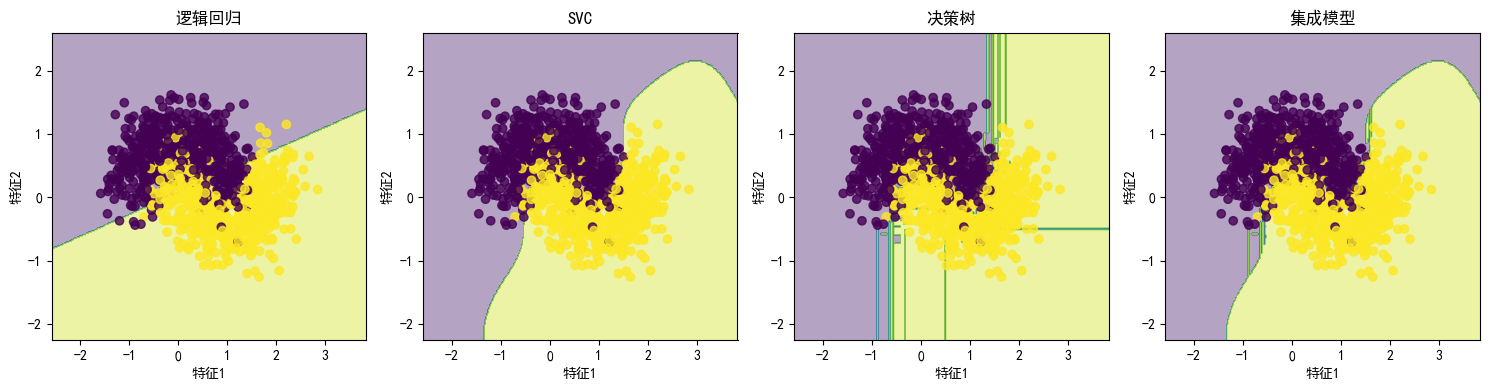

In [ ]:
X_sample = X_test[:1000]
y_sample = y_test[:1000]
# 创建网格点以可视化决策边界
x_min, x_max = X_sample[:, 0].min() - 1, X_sample[:, 0].max() + 1
y_min, y_max = X_sample[:, 1].min() - 1, X_sample[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 创建子图
plt.figure(figsize=(15, 4))
classifiers = [lr, svc, dt, voting_clf]
titles = ['逻辑回归', 'SVC', '决策树', '集成模型']

# 绘制每个分类器的决策边界
for idx, clf in enumerate(classifiers):
    plt.subplot(1, 4, idx + 1)

    # 预测网格点的类别
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 绘制决策边界和散点图
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, alpha=0.8)
    plt.title(titles[idx])
    plt.xlabel('特征1')
    plt.ylabel('特征2')

plt.tight_layout()
plt.show()

### 手动集成学习

In [ ]:
ensemble_pred = np.array((lr_pred + svc_pred + dt_pred) >= 2, dtype='int')
# 计算手动集成学习的准确率
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("手动集成学习准确率:", ensemble_accuracy)

手动集成学习准确率: 0.9044


## 软投票

In [ ]:

# 创建软投票集成分类器
ensemble_clf = VotingClassifier(
    estimators=[('lr', lr), ('svc', svc), ('dt', dt)],
    voting='soft'
)
# 由于SVC默认不返回概率，我们需要确保已经设置probability=True
# 如果没有设置，可以重新训练
if not hasattr(svc, 'predict_proba'):
    print("重新训练SVC以启用概率预测")
    svc_clf = SVC(probability=True, gamma='auto')
    svc_clf.fit(X_train, y_train)

    # 更新集成分类器中的SVC
    ensemble_clf.estimators[1] = ('svc', svc_clf)

# 训练集成分类器
ensemble_clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = ensemble_clf.predict(X_test)

# 计算并打印准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'软投票集成分类器的准确率: {accuracy:.4f}')

print('逻辑回归准确率:', accuracy_score(y_test, lr_pred))
print('SVC准确率:', accuracy_score(y_test, svc_pred))
print('决策树准确率:', accuracy_score(y_test, dt_pred))

重新训练SVC以启用概率预测
软投票集成分类器的准确率: 0.8981
逻辑回归准确率: 0.8535
SVC准确率: 0.9123
决策树准确率: 0.875


## BaggingClassifier

In [ ]:
# 导入所需的库
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# 创建基于决策树的Bagging分类器
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_classifier = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,  # 使用10个基分类器
    random_state=42,
    bootstrap=True,  # 
    oob_score=True
)

# 训练Bagging分类器
bagging_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = bagging_classifier.predict(X_test)

# 计算准确率
bag_accuracy = accuracy_score(y_test, y_pred)
print(f'Bagging分类器的准确率: {accuracy:.4f}')
print("决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))


Bagging分类器的准确率: 0.8964
决策树(基分类器)准确率: 0.875


### njobs参数,多线程单线程


In [ ]:
import time

# 创建基于决策树的Bagging分类器
base_estimator = DecisionTreeClassifier(random_state=42)

# 单线程训练
bagging_single = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42,
    bootstrap=True,
    oob_score=True,
    n_jobs=1  # 单线程
)

start_time = time.time()
bagging_single.fit(X_train, y_train)
single_time = time.time() - start_time
y_pred_single = bagging_single.predict(X_test)
accuracy_single = accuracy_score(y_test, y_pred_single)

# 多线程训练
bagging_multi = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1  # 使用所有可用CPU核心
)

start_time = time.time()
bagging_multi.fit(X_train, y_train)
multi_time = time.time() - start_time
y_pred_multi = bagging_multi.predict(X_test)
accuracy_multi = accuracy_score(y_test, y_pred_multi)

print(f'单线程Bagging分类器:')
print(f'训练时间: {single_time:.2f}秒')
print(f'准确率: {accuracy_single:.4f}')
print('\n多线程Bagging分类器:')
print(f'训练时间: {multi_time:.2f}秒')
print(f'准确率: {accuracy_multi:.4f}')
print("\n决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))


单线程Bagging分类器:
训练时间: 11.41秒
准确率: 0.9014

多线程Bagging分类器:
训练时间: 8.39秒
准确率: 0.9014

决策树(基分类器)准确率: 0.875


### 加入bootstrap_features参数

In [ ]:

# 创建基于决策树的Bagging分类器
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_classifier = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,  # 使用10个基分类器
    random_state=42,
    bootstrap=True,  # 
    oob_score=True,
    bootstrap_features=True
)

# 训练Bagging分类器
bagging_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = bagging_classifier.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Bagging分类器的准确率: {accuracy:.4f}')
print("决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))


Bagging分类器的准确率: 0.8964
决策树(基分类器)准确率: 0.875


# ExtraTreesClassifier

In [ ]:
# ExtraTrees（Extremely Randomized Trees）是一种集成学习方法，
# 它与随机森林类似，但在树的构建过程中引入了更多的随机性,随机阈值
from sklearn.ensemble import ExtraTreesClassifier

# 创建ExtraTrees分类器
et_clf = ExtraTreesClassifier(
    n_estimators=100,  # 使用100个树
    criterion='gini',  # 使用基尼不纯度作为分裂标准
    max_depth=None,  # 树的最大深度，None表示不限制
    min_samples_split=2,  # 分裂一个内部节点所需的最小样本数
    min_samples_leaf=1,  # 在叶节点处需要的最小样本数
    max_features='sqrt',  # 寻找最佳分割时考虑的特征数量
    bootstrap=False,  # 是否使用bootstrap抽样
    random_state=42,  # 随机种子，确保结果可复现
    n_jobs=-1  # 使用所有可用的CPU核心)
)
# 训练模型
et_clf.fit(X_train, y_train)

# 预测
y_pred = et_clf.predict(X_test)
# 计算ExtraTrees的预测准确率
extra_trees_accuracy = accuracy_score(y_test, y_pred)
# 输出结果
print("决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))
print("Bagging集成准确率:", bag_accuracy)
print("ExtraTrees集成准确率:", extra_trees_accuracy)

决策树(基分类器)准确率: 0.875
Bagging集成准确率: 0.9014
ExtraTrees集成准确率: 0.9018


# 串行

## adaBoosting

In [ ]:
# 导入必要的库
from sklearn.ensemble import AdaBoostClassifier

# 创建基分类器 - 决策树
base_estimator = DecisionTreeClassifier(max_depth=1)

# 创建AdaBoost分类器
ada_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,  # 弱分类器的数量
    learning_rate=1.0,
    random_state=42
)

# 训练模型
ada_clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = ada_clf.predict(X_test)

# 计算准确率
adabost_accuracy = accuracy_score(y_test, y_pred)
print(f'AdaBoost分类器的准确率: {adabost_accuracy:.4f}')
print("Bagging集成准确率:", bag_accuracy)
print("ExtraTrees集成准确率:", extra_trees_accuracy)

AdaBoost分类器的准确率: 0.8994
Bagging集成准确率: 0.9014
ExtraTrees集成准确率: 0.9018


## GBDT

GBDT分类器的准确率: 0.9124


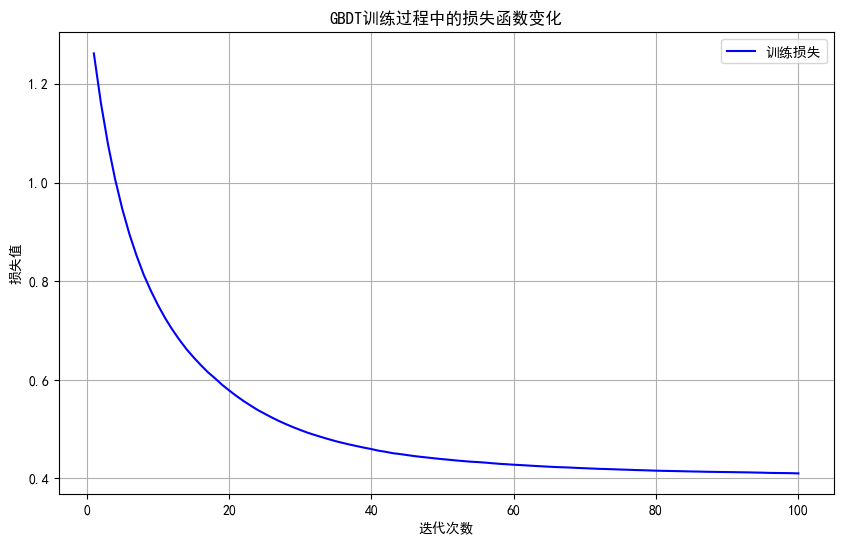

In [ ]:
# 导入必要的库
from sklearn.ensemble import GradientBoostingClassifier

# 创建GBDT分类器
gbdt = GradientBoostingClassifier(
    n_estimators=100,  # 弱分类器的数量
    learning_rate=0.1,  # 学习率
    max_depth=3,  # 决策树的最大深度
    min_samples_split=2,  # 分裂内部节点所需的最小样本数
    min_samples_leaf=1,  # 叶节点所需的最小样本数
    subsample=1.0,  # 用于拟合各个基础学习器的样本比例
    random_state=42  # 随机种子，确保结果可复现
)

# 训练模型
gbdt.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = gbdt.predict(X_test)

# 计算并输出准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'GBDT分类器的准确率: {accuracy:.4f}')
# 绘制训练过程中的损失函数变化
import matplotlib.pyplot as plt

# 获取训练过程中的损失值
train_scores = gbdt.train_score_

# 创建迭代次数数组
iterations = range(1, len(train_scores) + 1)

# 绘制损失函数曲线
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_scores, 'b-', label='训练损失')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.title('GBDT训练过程中的损失函数变化')
plt.legend()
plt.grid(True)
plt.show()
